# Annotation
---

For cell type annotation in this single-cell RNA-seq analysis, both **manual** and **automated** approaches were used. The manual annotation was performed from two angles: one involved working from a table of known marker genes for expected cell types and checking their expression in the defined clusters, while the other focused on identifying highly expressed genes within the clusters and determining their association with known cell types or states. Additionally, automated annotation with tools like **CellTypist** ([Conde *et al.* 2022](http://doi.org/10.1126/science.abl5197)), which has built-in models (with a current focus on immune cell types), was applied. CellTypist uses logistic regression classifiers trained on reference datasets to assign cell types based on broader transcriptomic profiles.


Load packages and data:

In [ ]:
!pip install scanpy python-igraph leidenalg celltypist

In [4]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import celltypist
from celltypist import models

In [ ]:
# read .h5ad
adata = sc.read_h5ad('/content/drive/MyDrive/GC_scRNAseq_integrated.h5ad')
adata

AnnData object with n_obs × n_vars = 176785 × 26809
    obs: 'barcodes_file', 'features_file', 'dataset', 'dataset_id', 'batch', ' sample_id', 'sample_name', 'sample_type', 'patient', 'age', 'sex', 'location', 'phase', 'stage', 'lauren_class', 'medical_treatment', 'metastasized', 'TCGA_subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'scDblFinder_score', 'scDblFinder_class', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'dataset_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scVI_hvg2k', 'X_scVI_hvg3k', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'decontX_counts', '

### Clustering

Clustering using the scVI embedding groups cells with similar gene expression profiles, allowing for the identification of cell identities and states. Here, the Leiden algorithm is applied to the reduced-dimensional expression space, optimizing cluster structure based on Euclidean distances.

In [ ]:
# compute the neighbors using the X_scVI embedding
sc.pp.neighbors(adata, use_rep='X_scVI_hvg2k')
# compute the UMAP coordinates
sc.tl.umap(adata)

In [ ]:
# Leiden clustering  - resolution 2.0
sc.tl.leiden(adata, resolution=2.0, key_added='leiden_2', flavor='igraph', n_iterations=2, directed=False)

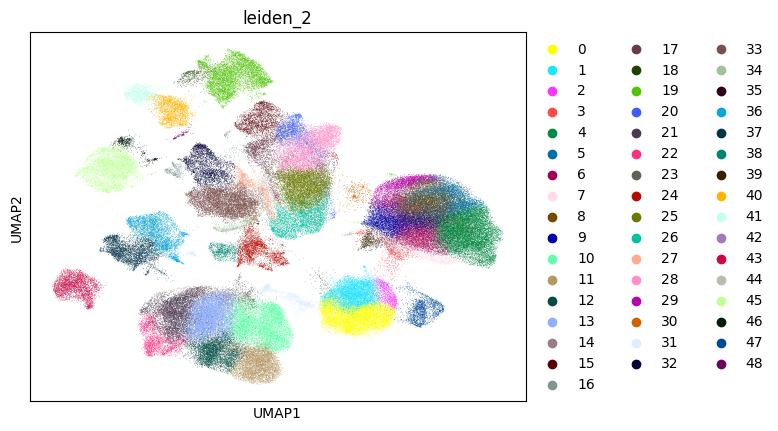

In [ ]:
sc.pl.umap(adata, color=['leiden_2'])

### Cluster-Specific Gene Expression

Calculate the differentially expressed genes for each cluster relative to the rest of the cells:

In [ ]:
# calculate genes differentially expressed between clusters
sc.tl.rank_genes_groups(adata, groupby='leiden_2', method='wilcoxon', key_added='dea_leiden_2')

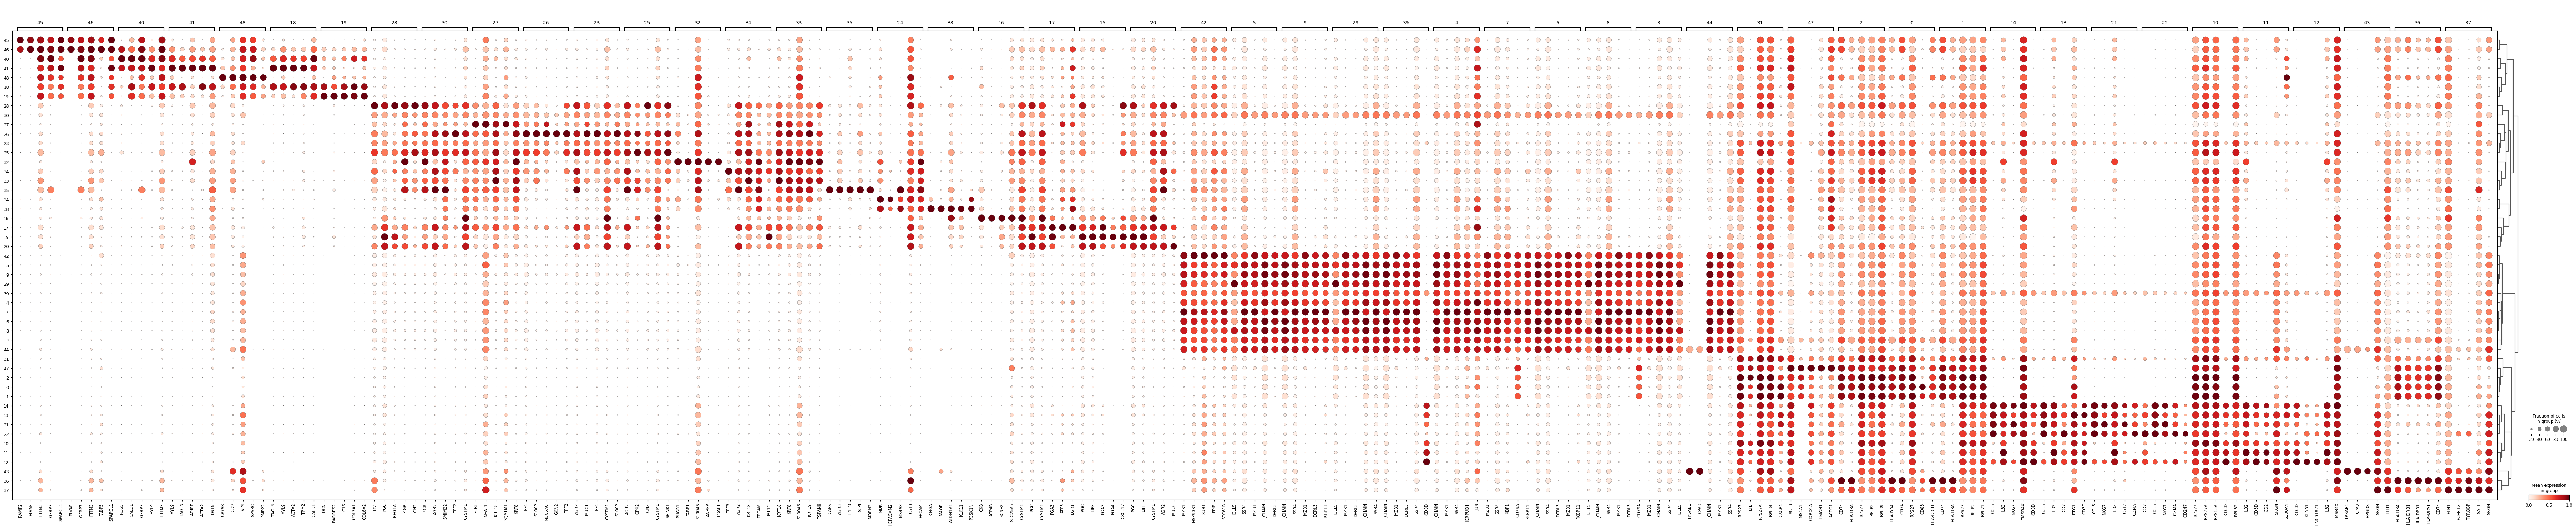

In [ ]:
# plot cluster-specific DEGs
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby='leiden_2',
    standard_scale='var',
    n_genes=5,
    key='dea_leiden_2',
)

In [ ]:
adata.write('/content/drive/MyDrive/GC_scRNAseq_clustered.h5ad', compression='gzip')

In [5]:
# read .h5ad
adata = sc.read_h5ad('/content/drive/MyDrive/GC_scRNAseq_clustered.h5ad')
adata

AnnData object with n_obs × n_vars = 176785 × 26809
    obs: 'barcodes_file', 'features_file', 'dataset', 'dataset_id', 'batch', ' sample_id', 'sample_name', 'sample_type', 'patient', 'age', 'sex', 'location', 'phase', 'stage', 'lauren_class', 'medical_treatment', 'metastasized', 'TCGA_subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', 'leiden_2', 'leiden_1', 'leiden_05'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'dataset_colors', 'dea_leiden_1', 'dea_leiden_2', 'dendrogram_leiden_1', 'dendrogram_leiden_2', 'hvg', 'leiden_05', 'leiden_05_colors', 'leid

After running sc.tl.filter_rank_genes_groups(), adata.write() will throw an error 'TypeError: Can't implicitly convert non-string objects to strings' this seems to be known but not solved though. Transforming all into string in .uns will cause issues when trying to load the anndata object again. (Bug: the rank_genes_groups() results are stored in record arrays (recarrays) and include NaNs after filtering which will lead to error since nullable strings are not supported)

In [ ]:
# filter the differentially expressed genes to select for more-cluster-specific differentially expressed genes
sc.tl.filter_rank_genes_groups(
    adata,
    min_in_group_fraction=0.2,
    max_out_group_fraction=0.2,
    key='dea_leiden_2',
    key_added='dea_leiden_2_filtered',
)

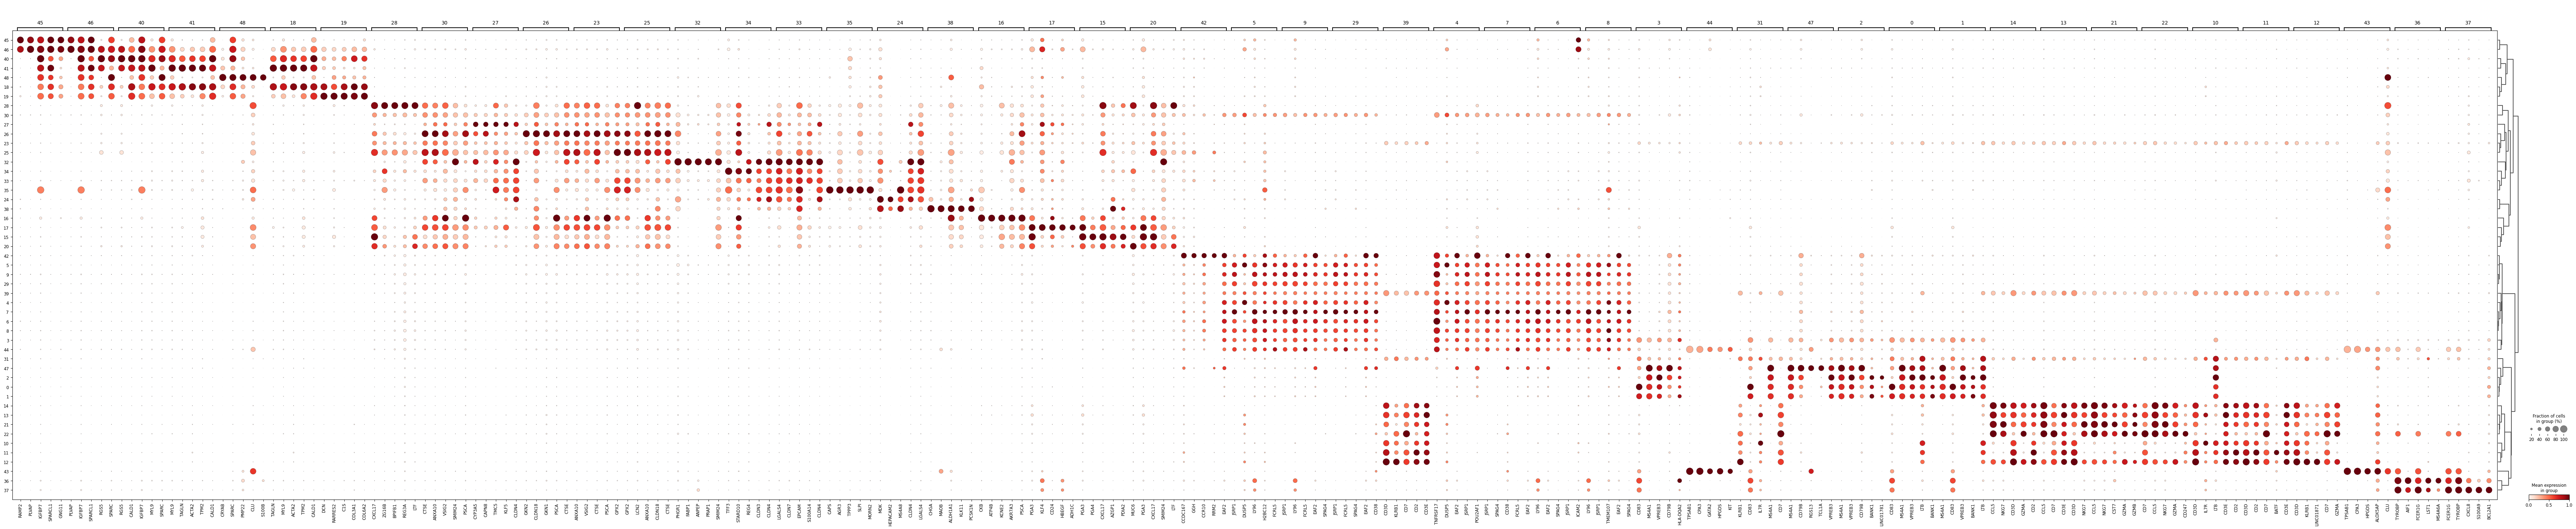

In [ ]:
# plot filtered cluster-specific DEGs
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby='leiden_2',
    standard_scale='var',
    n_genes=5,
    key='dea_leiden_2_filtered',
)

### Manual Celltype Annotation

#### Celltype Marker Genes

Tissue-type-specific marker genes were taken from the literature ( [Zhang *et al.* 2019](https://doi.org/10.1016/j.celrep.2019.04.052),  [Sathe *et al.* 2020](https://doi.org/10.1158/1078-0432.CCR-19-3231), [Busslinger *et al.* 2021](https://doi.org/10.1016/j.celrep.2021.108819), [Jeong *et al.* 2021](https://doi.org/10.1158/1078-0432.CCR-21-0792), [Hoft *et al.* 2022](https://doi.org/10.3389/fimmu.2022.902017), [Kumar *et al.* 2022](https://doi.org/10.1158/2159-8290.CD-21-0683), [Öling *et al.* 2024](https://doi.org/10.1186/s12915-024-01812-5)). Besides normal stomach cell types, the marker gene list includes those for cancer-related and pre-cancerous stages. This includes markers for gastric adenocarcinoma cells, indicating malignancy, and intestinal metaplasia (IM) cells, a premalignant transformation. Markers for cancer-associated fibroblasts (CAFs) highlight two subtypes: inflammatory CAFs (iCAFs), which aid in immune cell recruitment and tumor growth, and extracellular matrix CAFs (eCAFs), which promote cell migration, metastasis, and are linked to poorer outcomes.





In [ ]:
# read marker genes df
marker_genes_df = pd.read_csv('/content/drive/MyDrive/celltype_marker_genes.csv')
marker_genes_df.head()

Marker       Group                      Cell type  Reference  Sort
0    CDH1  epithelial                Epithelial cell  Kumar2022     0
1   CAPN8  epithelial            Gastric mucous cell  Öling2024     1
2  LGALS4  epithelial            Gastric mucous cell  Öling2024     1
3    VILL  epithelial            Gastric mucous cell  Öling2024     1
4    MUC6  epithelial  Gland mucous cell (Neck Cell)  Sathe2020     2

In [ ]:
# create dictionary from marker gene df
marker_genes = marker_genes_df.groupby('Group').apply(
    lambda x: {
        cell_type: list(x.loc[x['Cell type'] == cell_type, 'Marker'])
        for cell_type in x.sort_values(by='Sort')['Cell type']
    }
).to_dict()

In [ ]:
# retain only those marker genes observed in the data
marker_genes_observed = dict()

for group in marker_genes.keys():
    marker_genes_observed[group] = {}
    for ct, markers in marker_genes[group].items():
        markers_observed = [marker for marker in markers if marker in adata.var.index]
        if markers_observed:
            marker_genes_observed[group][ct] = markers_observed

marker_genes_observed


{'epithelial': {'Epithelial cell': ['CDH1'],
  'Gastric mucous cell': ['CAPN8', 'LGALS4', 'VILL'],
  'Gland mucous cell (Neck Cell)': ['MUC6', 'TFF2'],
  'Surface mucous cell (Pit Cell)': ['GKN1', 'GKN2', 'MUC5AC', 'TFF1'],
  'Parietal cell': ['ATP4A', 'ATP4B', 'GIF', 'MFSD4A'],
  'Chief cell': ['AZGP1', 'LIPF', 'PGA3', 'PGA4', 'PGC'],
  'Enteroendocrine cell ': ['GHRL'],
  'Enteroendocrine cell - X cell': ['GHRL'],
  'Enteroendocrine cell - G cell': ['GAST'],
  'Enteroendocrine cell - D cell': ['SST'],
  'Enteroendocrine cell': ['ARX',
   'CHGA',
   'GAST',
   'HDC',
   'INSM1',
   'SST',
   'ST18'],
  'Isthmus cell': ['MKI67', 'STMN1'],
  'Tuft cell': ['SH2D6', 'TRPM5'],
  'Intestinal cell (gastric IM)': ['CDX1', 'CDX2', 'REG4', 'TFF3'],
  'Gastric adenocarcinoma cell': ['EPCAM', 'TFF3']},
 'lymphoid': {'B cell': ['CD19', 'CD79A', 'CD79B', 'MS4A1', 'MZB1'],
  'Plasma cell': ['IGKC', 'JCHAIN', 'SDC1', 'TNFRSF17'],
  'T cell': ['CD2', 'CD3D', 'CD3E', 'CD3E', 'CD3G', 'CD3G'],
  'CD4+ T 

#### Coarse Annotation - Main Groups of Cells - Manual

In [6]:
# store manual annotation (Leiden 2) - coarse
coarse_annotation = {
    '0': 'LYMPHOID',
    '1': 'LYMPHOID',
    '2': 'LYMPHOID',
    '3': 'LYMPHOID',
    '4': 'LYMPHOID',
    '5': 'LYMPHOID',
    '6': 'LYMPHOID',
    '7': 'LYMPHOID',
    '8': 'LYMPHOID',
    '9': 'LYMPHOID',
    '10': 'LYMPHOID',
    '11': 'LYMPHOID',
    '12': 'LYMPHOID',
    '13': 'LYMPHOID',
    '14': 'LYMPHOID',
    '15': 'EPITHELIAL',
    '16': 'EPITHELIAL',
    '17': 'EPITHELIAL',
    '18': 'STROMAL',
    '19': 'STROMAL',
    '20': 'EPITHELIAL',
    '21': 'LYMPHOID',
    '22': 'LYMPHOID',
    '23': 'EPITHELIAL',
    '24': 'EPITHELIAL',
    '25': 'EPITHELIAL',
    '26': 'EPITHELIAL',
    '27': 'EPITHELIAL',
    '28': 'EPITHELIAL',
    '29': 'LYMPHOID',
    '30': 'LYMPHOID',
    '31': 'LYMPHOID',
    '32': 'EPITHELIAL',
    '33': 'EPITHELIAL',
    '34': 'EPITHELIAL',
    '35': 'EPITHELIAL',
    '36': 'MYELOID',
    '37': 'MYELOID',
    '38': 'EPITHELIAL',
    '39': 'LYMPHOID',
    '40': 'STROMAL',
    '41': 'STROMAL',
    '42': 'LYMPHOID',
    '43': 'MYELOID',
    '44': 'LYMPHOID',
    '45': 'STROMAL',
    '46': 'STROMAL',
    '47': 'LYMPHOID',
    '48': 'STROMAL',
}

adata.obs['coarse_celltype_annotation'] = adata.obs.leiden_2.map(coarse_annotation)

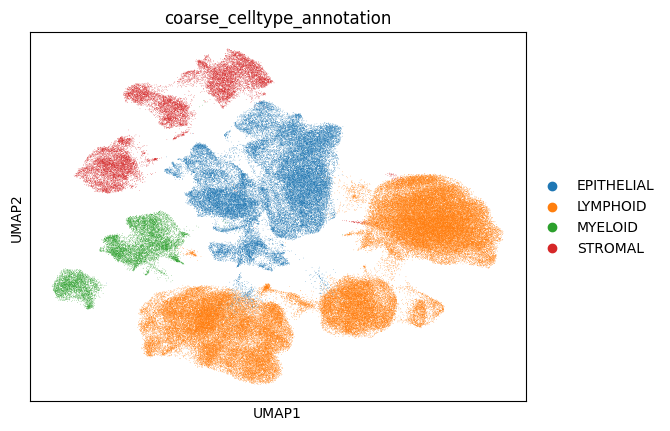

In [8]:
# plot coarse annotation
sc.pl.umap(adata, color=['coarse_celltype_annotation'])

#### Fine Annotation - Manual

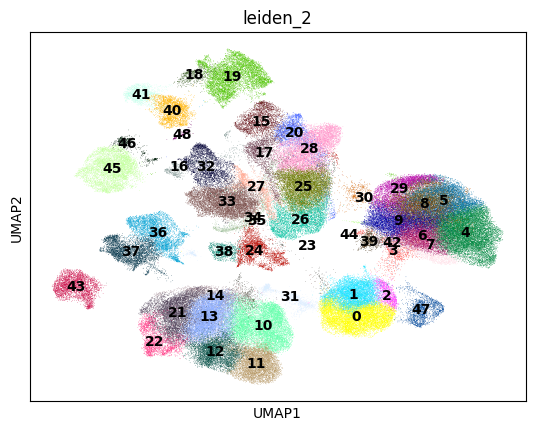

In [9]:
sc.pl.umap(adata, color=['leiden_2'], legend_loc='on data')

EPITHELIAL:


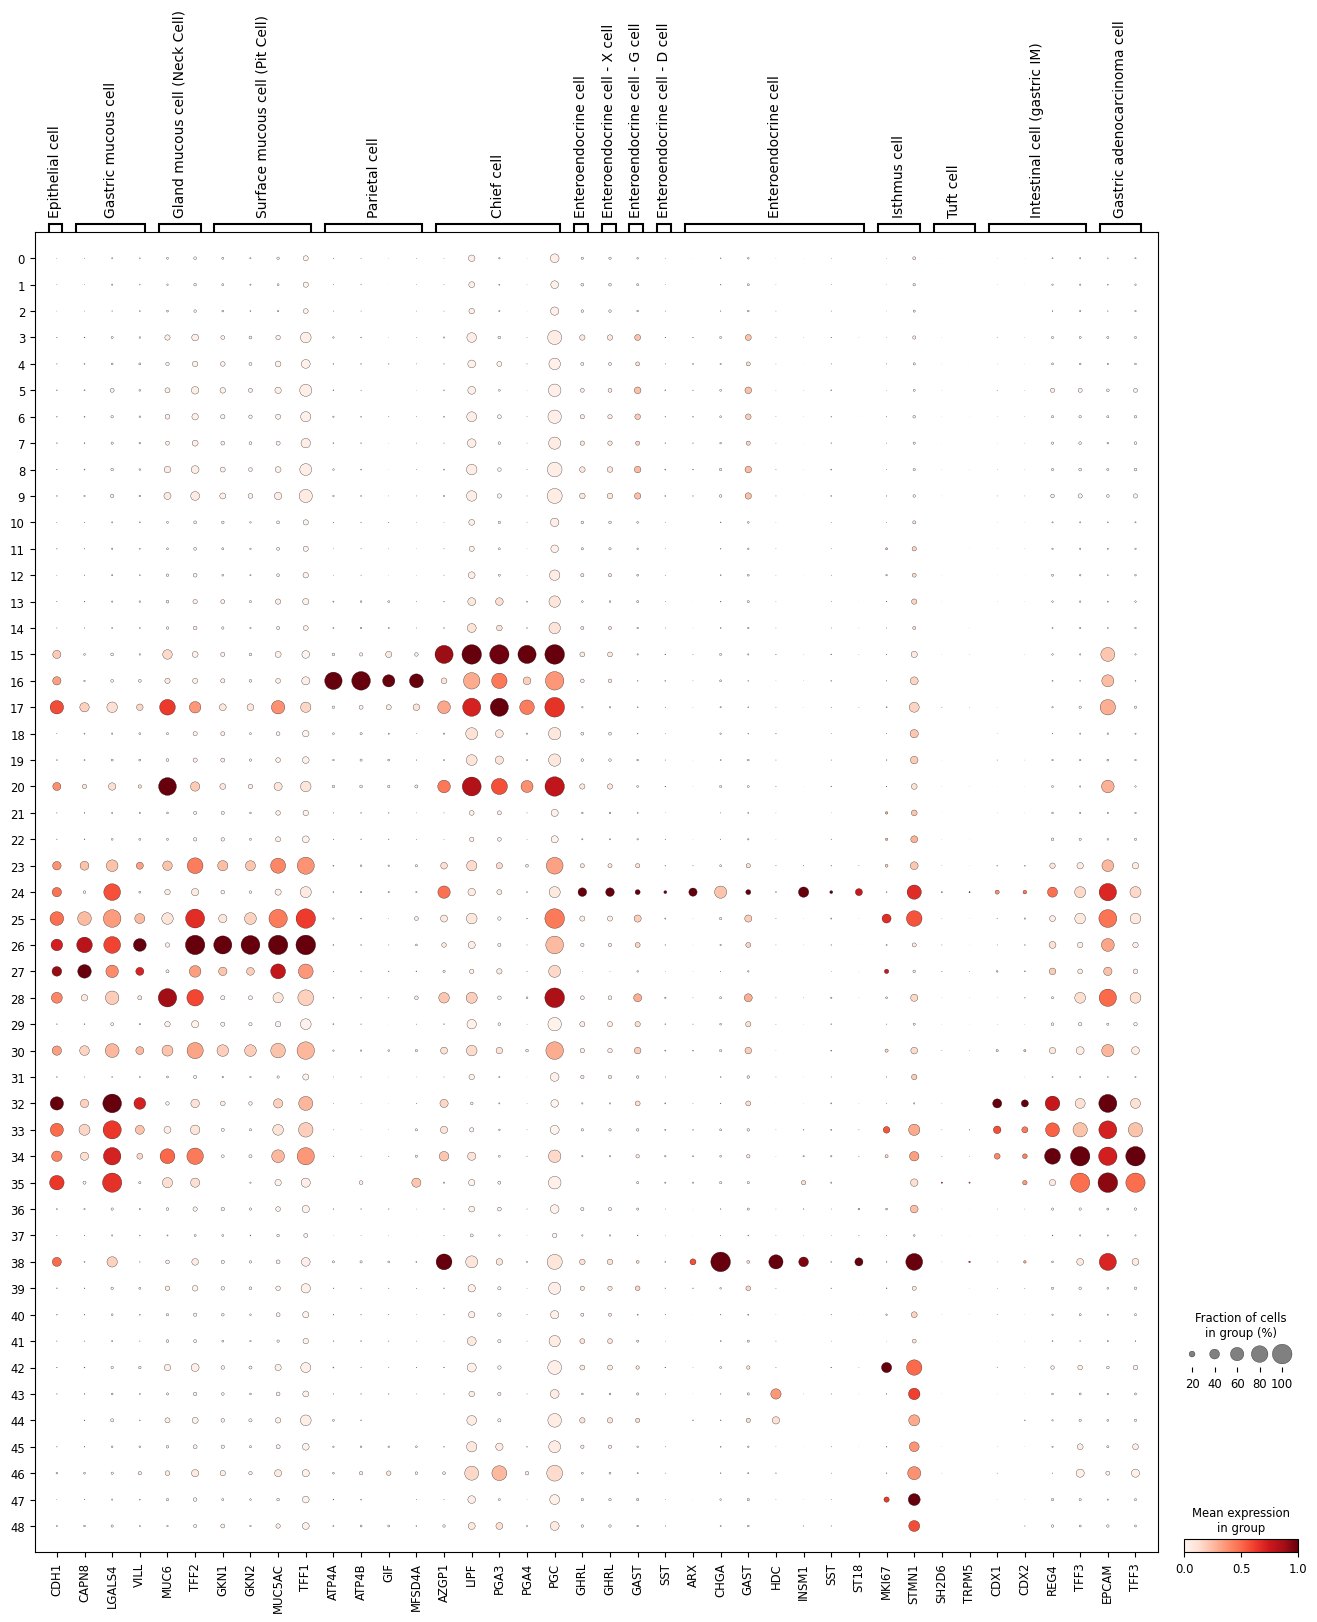

<Figure size 640x480 with 0 Axes>

LYMPHOID:


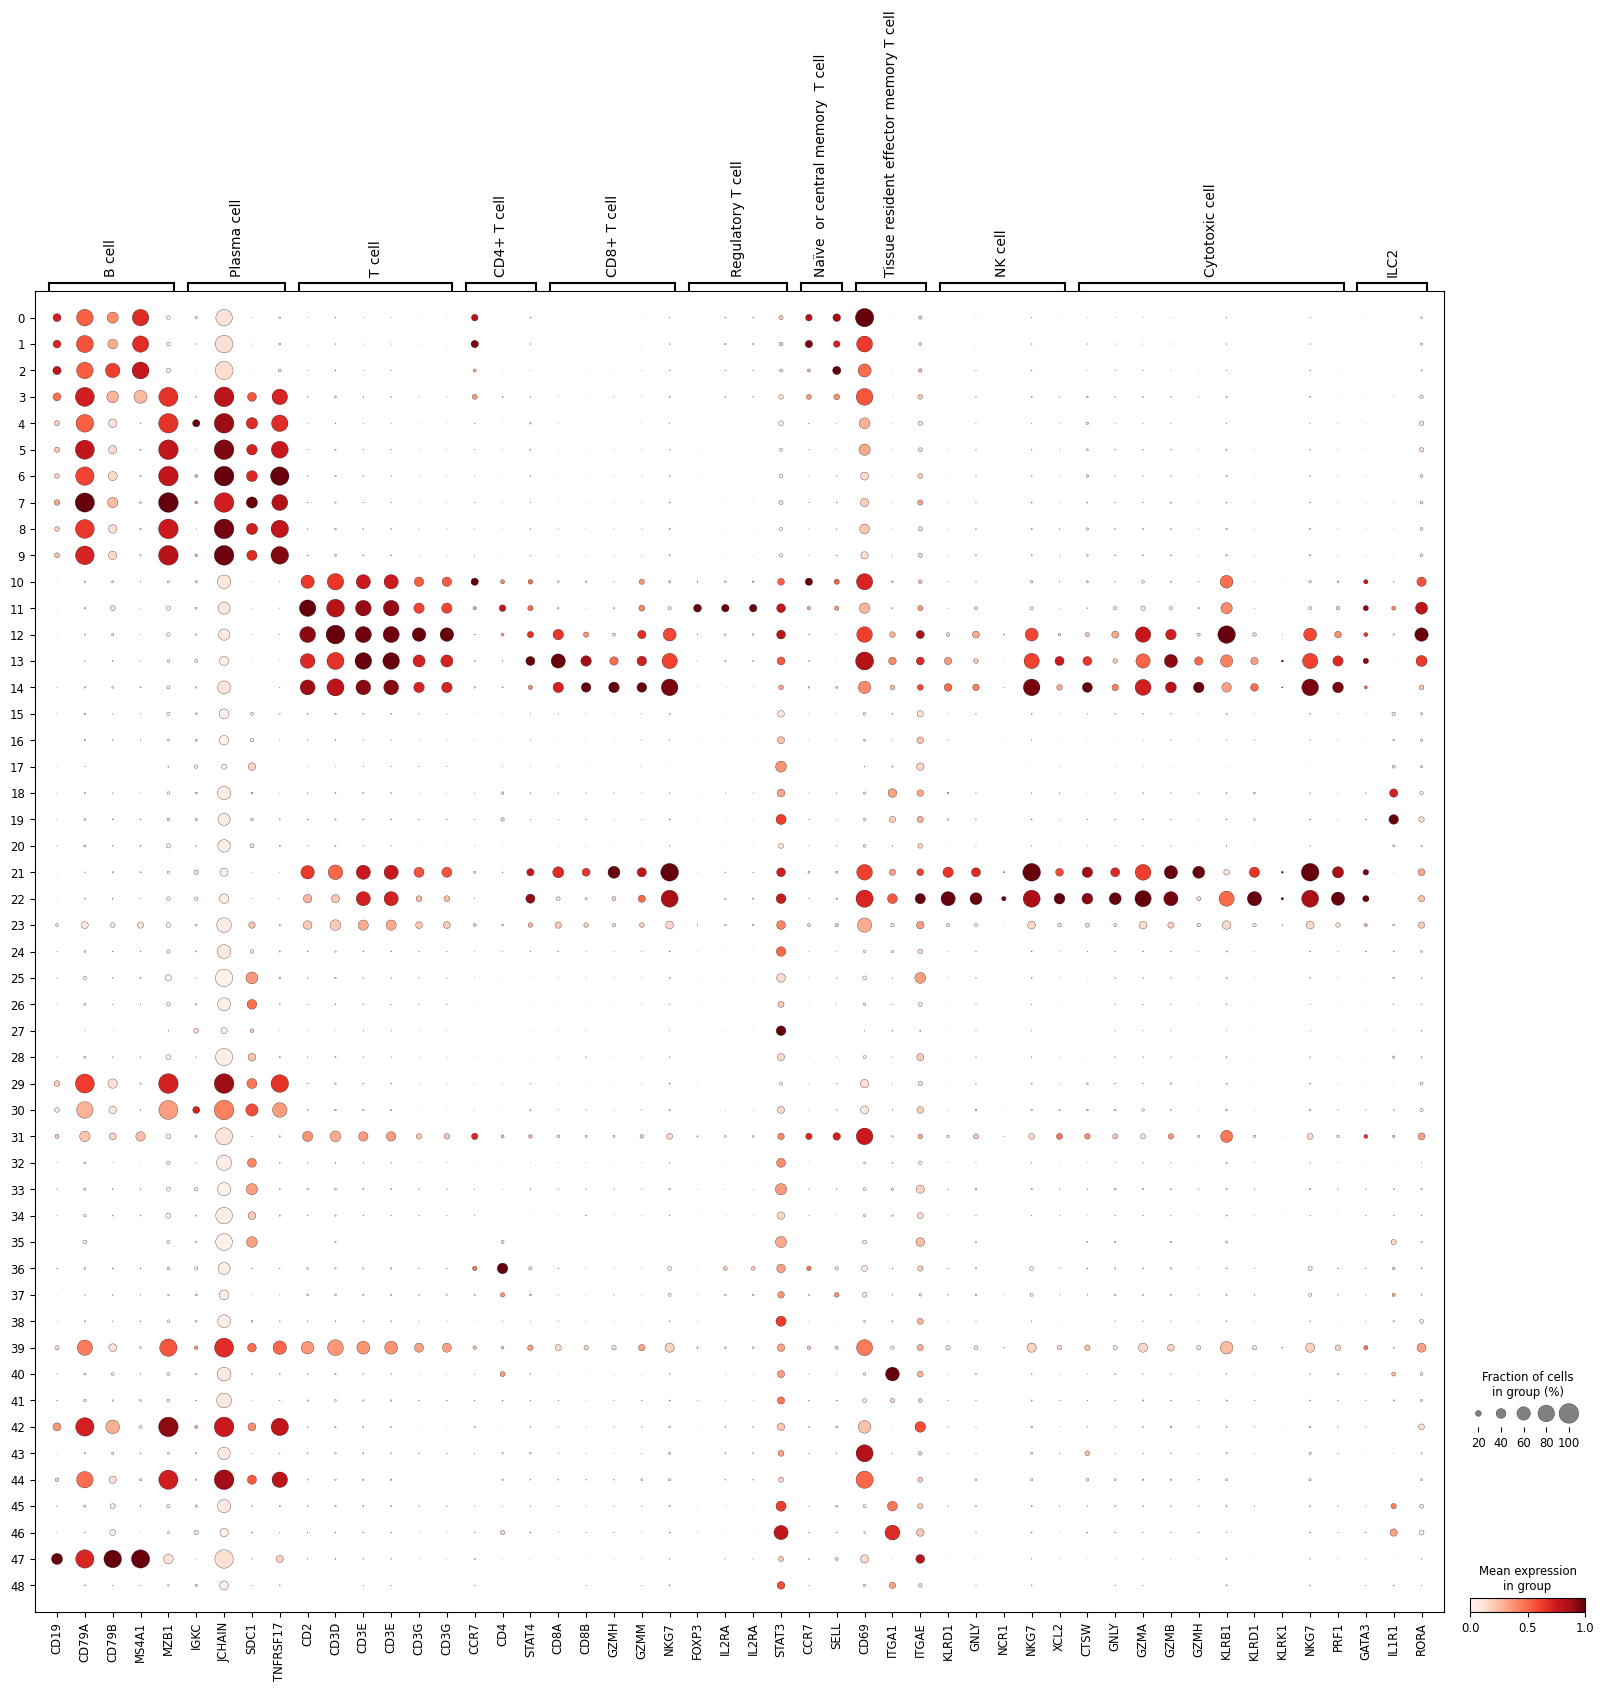

<Figure size 640x480 with 0 Axes>

MITOTIC:


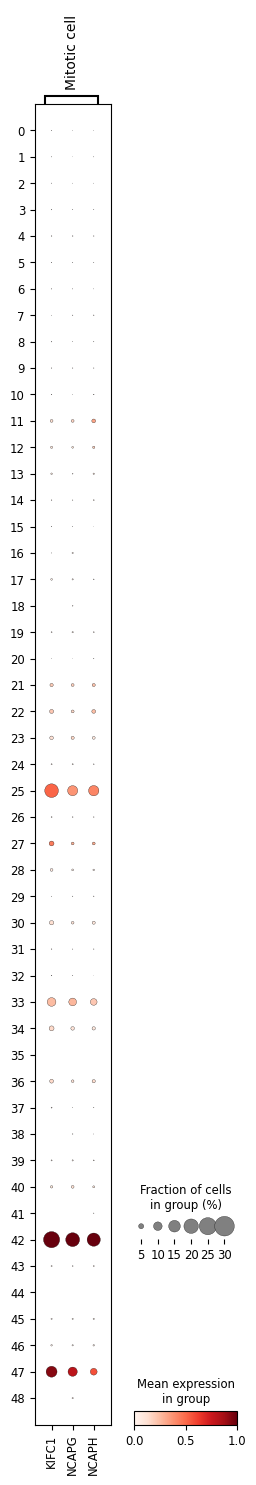

<Figure size 640x480 with 0 Axes>

MYELOID:


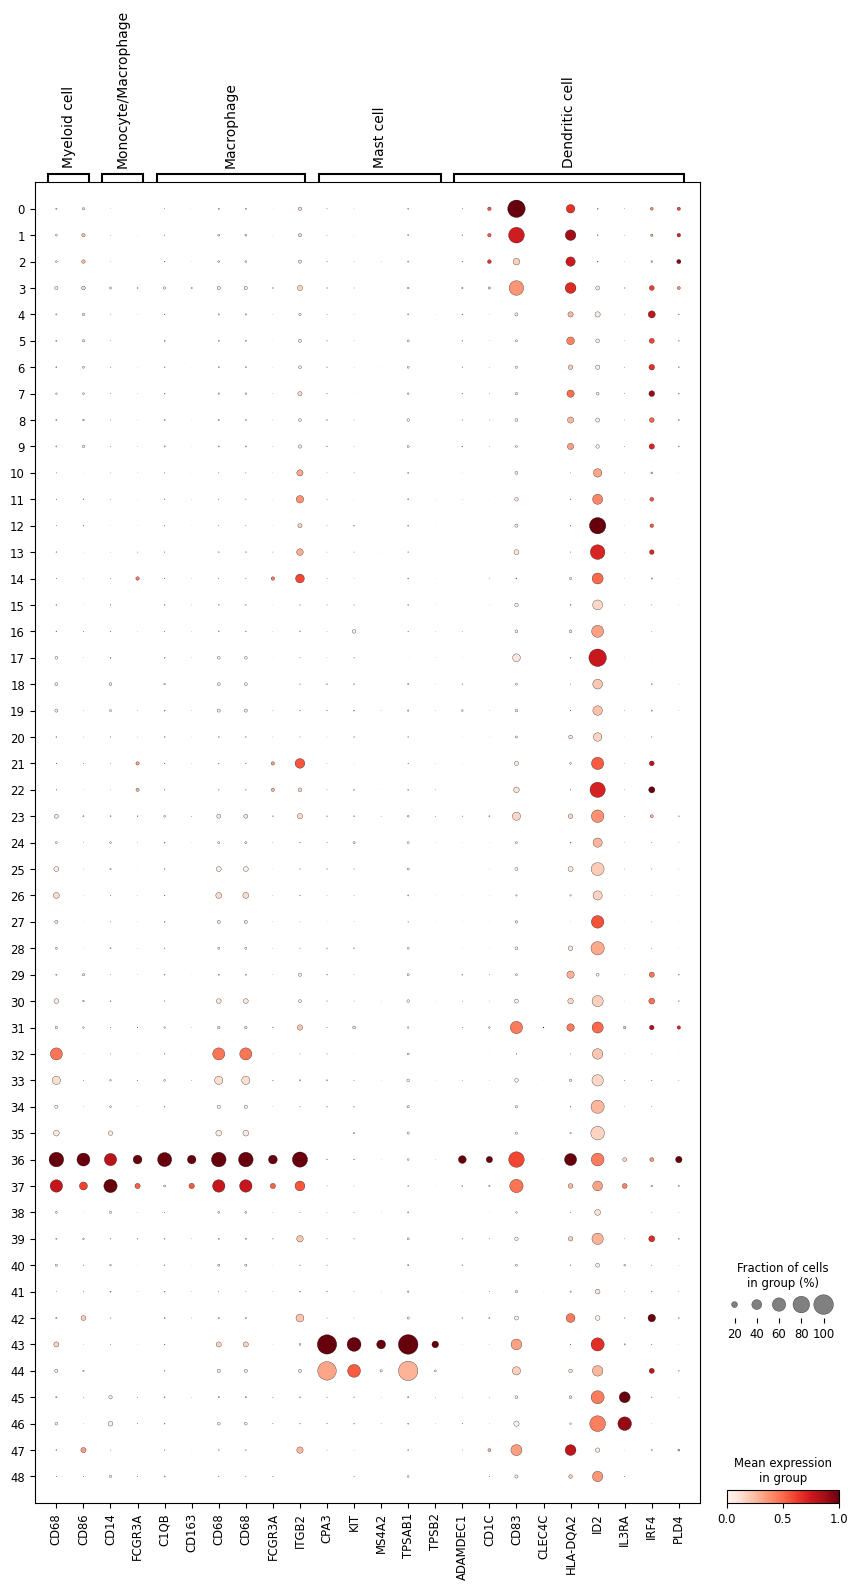

<Figure size 640x480 with 0 Axes>

STEM_CELL:


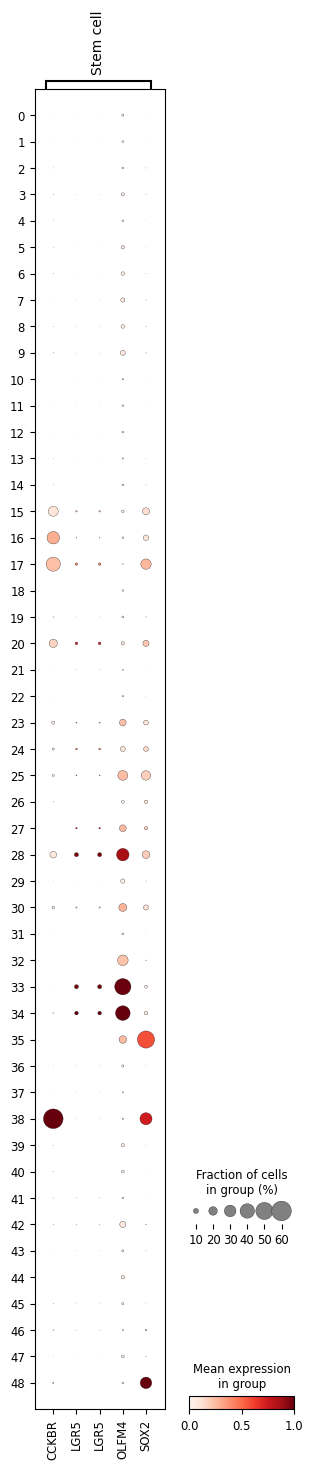

<Figure size 640x480 with 0 Axes>

STROMAL:


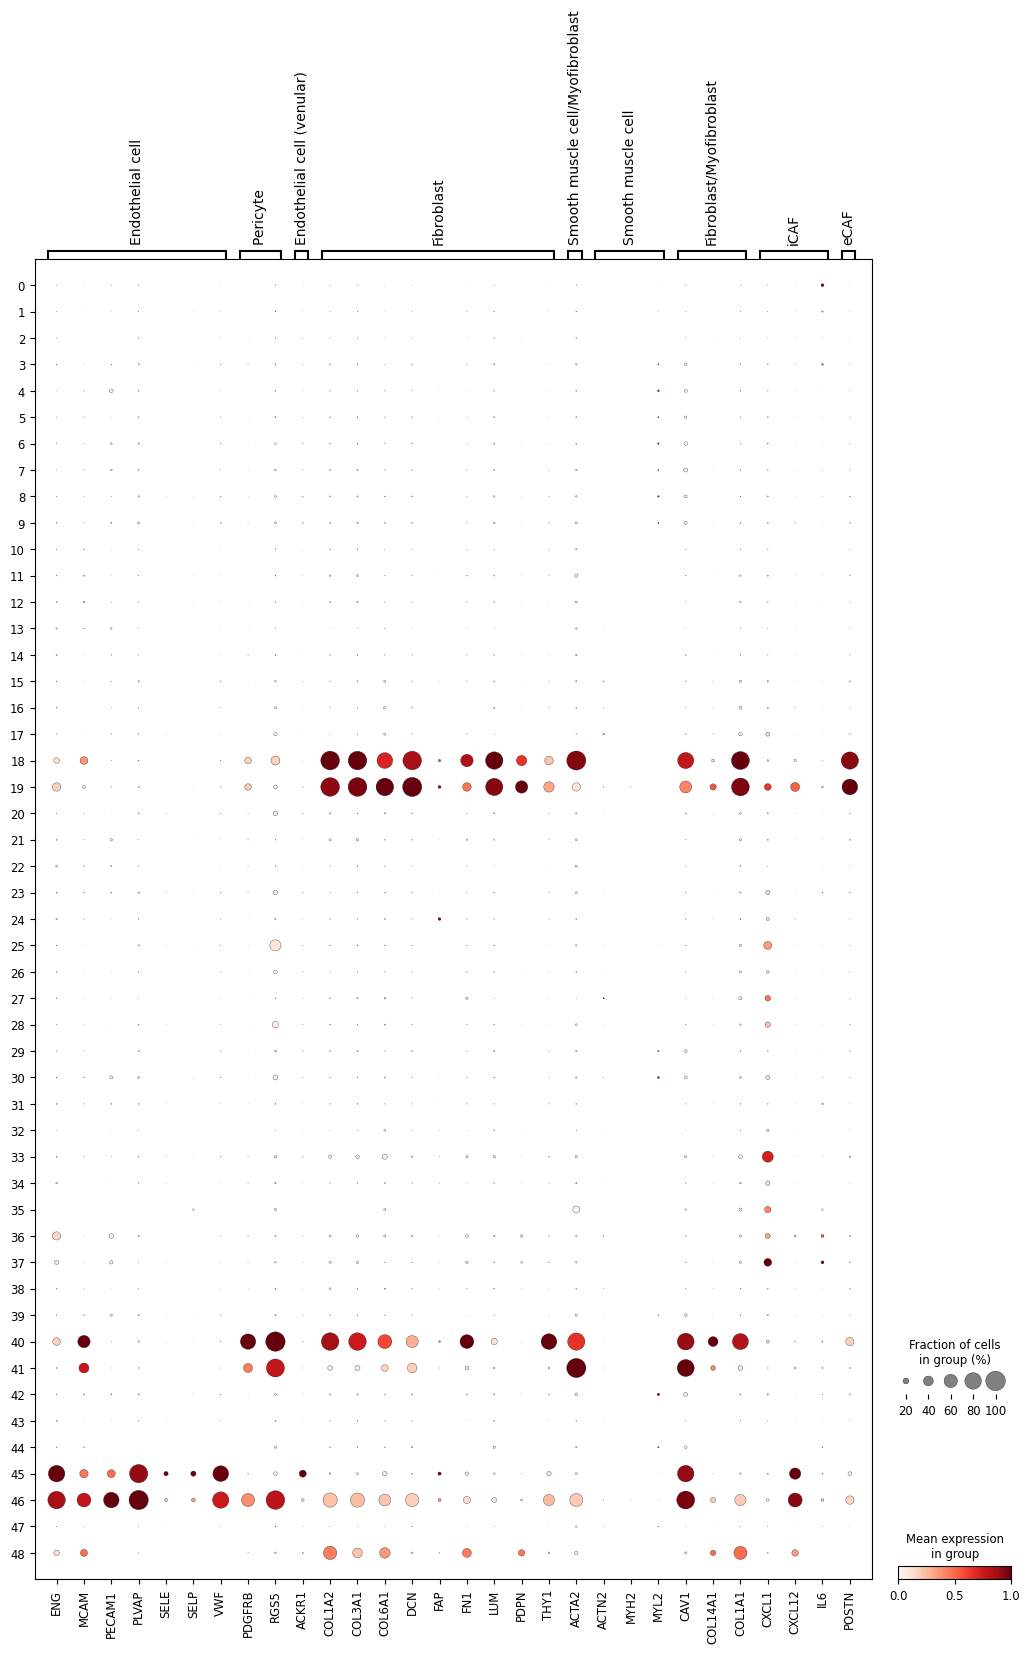

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot marker genes - Leiden 2.0
for group in list(marker_genes_observed.keys()):
    print(f'{group.upper()}:')

    sc.pl.dotplot(
        adata,
        groupby='leiden_2',
        var_names=marker_genes_observed[group],
        standard_scale='var',  # standard scale: normalize each gene to range from 0 to 1
    )

    plt.tight_layout()
    plt.show();

In [10]:
# store manual annotation (Leiden 2) - fine
fine_annotation = {
    '0': 'B cells',
    '1': 'B cells',
    '2': 'B cells',
    '3': 'Plasma cells',
    '4': 'Plasma cells',
    '5': 'Plasma cells',
    '6': 'Plasma cells',
    '7': 'Plasma cells',
    '8': 'Plasma cells',
    '9': 'Plasma cells',
    '10': 'T cells',
    '11': 'T cells',
    '12': 'T cells',
    '13': 'T cells',
    '14': 'T cells',
    '15': 'Chief cells',
    '16': 'Parietal cells',
    '17': 'Chief cells',
    '18': 'Fibroblasts',
    '19': 'Fibroblasts',
    '20': 'Chief cells',
    '21': 'T cells',
    '22': 'T cells',
    '23': 'Mucous cells with T cell markers',
    '24': 'Enteroendocrine cells',
    '25': 'Surface mucous cells (Pit cells)',
    '26': 'Surface mucous cells (Pit cells)',
    '27': 'Surface mucous cells (Pit cells)',
    '28': 'Gland mucous cells (Neck cells)',
    '29': 'Plasma cells',
    '30': 'Plasma cells',
    '31': 'T cells',
    '32': 'Mucous cells (abnormal/malignant)',
    '33': 'Mucous cells (abnormal/malignant)',
    '34': 'Mucous cells (abnormal/malignant)',
    '35': 'Mucous cells (abnormal/malignant)',
    '36': 'Macrophages',
    '37': 'Macrophages',
    '38': 'Enteroendocrine cells',
    '39': 'Plasma and T cell markers',
    '40': 'Pericytes',
    '41': 'Pericytes',
    '42': 'Plasma cells',
    '43': 'Mast cells',
    '44': 'Plasma cells',
    '45': 'Endothelial cells',
    '46': 'Endothelial cells',
    '47': 'B cells',
    '48': 'Fibroblasts',
    }

adata.obs['fine_celltype_annotation'] = adata.obs.leiden_2.map(fine_annotation)

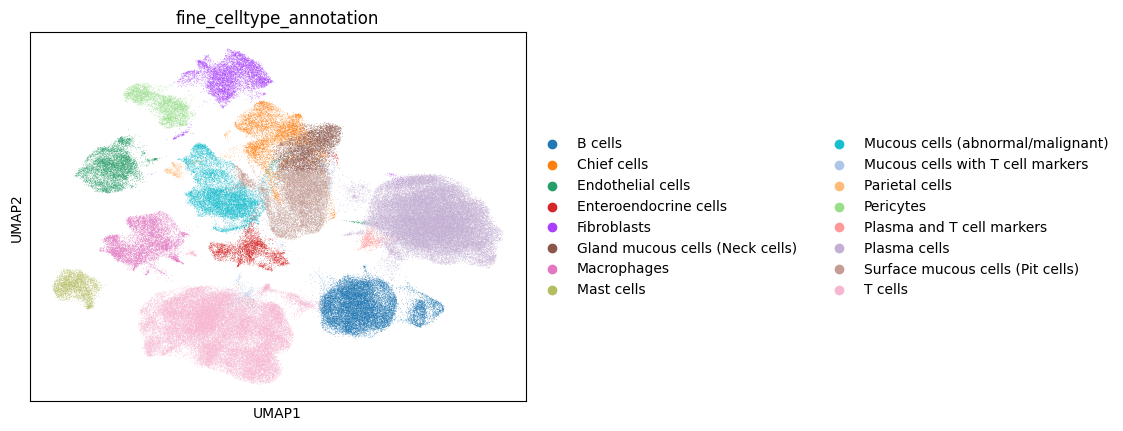

In [11]:
# plot fine annotation
sc.pl.umap(adata, color=['fine_celltype_annotation'])

### Celltypist Annotation

In order to further annotate immune-related cell types, the immune models of CellTypist ([Conde *et al.* 2022](https://doi.org/10.1126/science.abl5197)) are employed to predict immune-related cell types present in the data.

In [12]:
# show all available models in celltypist
models.models_description()

model  \
0                        Immune_All_Low.pkl   
1                       Immune_All_High.pkl   
2                    Adult_COVID19_PBMC.pkl   
3   Adult_CynomolgusMacaque_Hippocampus.pkl   
4                       Adult_Human_MTG.pkl   
5           Adult_Human_PancreaticIslet.pkl   
6          Adult_Human_PrefrontalCortex.pkl   
7                      Adult_Human_Skin.pkl   
8                       Adult_Mouse_Gut.pkl   
9             Adult_Mouse_OlfactoryBulb.pkl   
10                Adult_Pig_Hippocampus.pkl   
11      Adult_RhesusMacaque_Hippocampus.pkl   
12                 Autopsy_COVID19_Lung.pkl   
13         COVID19_HumanChallenge_Blood.pkl   
14             COVID19_Immune_Landscape.pkl   
15                   Cells_Adult_Breast.pkl   
16                     Cells_Fetal_Lung.pkl   
17                   Cells_Human_Tonsil.pkl   
18               Cells_Intestinal_Tract.pkl   
19                    Cells_Lung_Airway.pkl   
20               Developing_Human_Brain.pkl   
21              Developing_Human_Gonads.pkl   
22         Developing_Human_Hippocampus.pkl   
23              Developing_Human_Organs.pkl   
24              Developing_Human_Thymus.pkl   
25               Developing_Mouse_Brain.pkl   
26         Developing_Mouse_Hippocampus.pkl   
27            Fetal_Human_AdrenalGlands.pkl   
28                 Fetal_Human_Pancreas.pkl   
29                Fetal_Human_Pituitary.pkl   
30                   Fetal_Human_Retina.pkl   
31                     Fetal_Human_Skin.pkl   
32                  Healthy_Adult_Heart.pkl   
33                 Healthy_COVID19_PBMC.pkl   
34                  Healthy_Human_Liver.pkl   
35                  Healthy_Mouse_Liver.pkl   
36          Human_AdultAged_Hippocampus.pkl   
37              Human_Colorectal_Cancer.pkl   
38           Human_Developmental_Retina.pkl   
39              Human_Embryonic_YolkSac.pkl   
40                       Human_IPF_Lung.pkl   
41       Human_Longitudinal_Hippocampus.pkl   
42                     Human_Lung_Atlas.pkl   
43                        Human_PF_Lung.pkl   
44               Human_Placenta_Decidua.pkl   
45                  Lethal_COVID19_Lung.pkl   
46                  Mouse_Dentate_Gyrus.pkl   
47          Mouse_Isocortex_Hippocampus.pkl   
48         Mouse_Postnatal_DentateGyrus.pkl   
49                    Mouse_Whole_Brain.pkl   
50                   Nuclei_Lung_Airway.pkl   
51                      Pan_Fetal_Human.pkl   

                                          description  
0   immune sub-populations combined from 20 tissue...  
1   immune populations combined from 20 tissues of...  
2   peripheral blood mononuclear cell types from C...  
3   cell types from the hippocampus of adult cynom...  
4   cell types and subtypes (10x-based) from the a...  
5   cell types from pancreatic islets of healthy a...  
6   cell types and subtypes from the adult human d...  
7            cell types from human healthy adult skin  
8   cell types in the adult mouse gut combined fro...  
9    cell types from the olfactory bulb of adult mice  
10          cell types from the adult pig hippocampus  
11  cell types from the hippocampus of adult rhesu...  
12  cell types from the lungs of 16 SARS-CoV-2 inf...  
13  detailed blood cell states from 16 individuals...  
14  immune subtypes from lung and blood of COVID-1...  
15             cell types from the adult human breast  
16    cell types from human embryonic and fetal lungs  
17      tonsillar cell types from humans (3-65 years)  
18  intestinal cells from fetal, pediatric (health...  
19  cell populations from scRNA-seq of five locati...  
20  cell types from the first-trimester developing...  
21  cell types of human gonadal and adjacent extra...  
22   cell types from the developing human hippocampus  
23  cell types of five endoderm-derived organs in ...  
24  cell populations in embryonic, fetal, pediatri...  
25  cell types from the embryonic mouse brain betw...  
26  cell types from the mouse hipp

In [13]:
# download models for immune cells: Immune_All_Low and Immune_All_High (these annotate immune cell types finer annotation level (low) and coarser (high))
models.download_models(force_update=True, model=['Immune_All_High.pkl', 'Immune_All_Low.pkl'])

In [14]:
# load models
model_high = models.Model.load(model='Immune_All_High.pkl')
model_low = models.Model.load(model='Immune_All_Low.pkl')


In [15]:
# check cell types of  coarser 'Immune_All_High' model
model_high.cell_types

array(['B cells', 'B-cell lineage', 'Cycling cells', 'DC', 'DC precursor',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ETP',
       'Early MK', 'Endothelial cells', 'Epithelial cells',
       'Erythrocytes', 'Erythroid', 'Fibroblasts', 'Granulocytes',
       'HSC/MPP', 'ILC', 'ILC precursor', 'MNP', 'Macrophages',
       'Mast cells', 'Megakaryocyte precursor',
       'Megakaryocytes/platelets', 'Mono-mac', 'Monocyte precursor',
       'Monocytes', 'Myelocytes', 'Plasma cells', 'Promyelocytes',
       'T cells', 'pDC', 'pDC precursor'], dtype=object)

In [16]:
# check cell types of finer 'Immune_All_Low' model
model_low.cell_types

array(['Age-associated B cells', 'Alveolar macrophages', 'B cells',
       'CD16+ NK cells', 'CD16- NK cells', 'CD8a/a', 'CD8a/b(entry)',
       'CMP', 'CRTAM+ gamma-delta T cells', 'Classical monocytes',
       'Cycling B cells', 'Cycling DCs', 'Cycling NK cells',
       'Cycling T cells', 'Cycling gamma-delta T cells',
       'Cycling monocytes', 'DC', 'DC precursor', 'DC1', 'DC2', 'DC3',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ELP',
       'ETP', 'Early MK', 'Early erythroid', 'Early lymphoid/T lymphoid',
       'Endothelial cells', 'Epithelial cells', 'Erythrocytes',
       'Erythrophagocytic macrophages', 'Fibroblasts',
       'Follicular B cells', 'Follicular helper T cells', 'GMP',
       'Germinal center B cells', 'Granulocytes', 'HSC/MPP',
       'Hofbauer cells', 'ILC', 'ILC precursor', 'ILC1', 'ILC2', 'ILC3',
       'Intermediate macrophages', 'Intestinal macrophages',
       'Kidney-resident macrophages', 'Kupffer cells',
       'Large pre-B cell

In [ ]:
# prepare data for celltypist
adata.X = adata.layers['counts'].astype(float)  # set .X to raw counts
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10**4)  # normalize to 10,000 counts per cell
sc.pp.log1p(adata)  # log-transform



In [18]:
 # force garbage collection
gc.collect()

16674

##### Coarse Annotation - Celltypist

In [19]:
# coarse cellytype annotation (immune cells) - celltypist

# initialize columns in .obs
adata.obs['celltypist_cell_label_coarse'] = pd.Series(index=adata.obs.index, dtype='str')
adata.obs['celltypist_conf_score_coarse'] = pd.Series(index=adata.obs.index, dtype='float')

# process in chunks to avoid running out of memory
subset_size = 20000  # set size of each subset/chunk as needed

for i in range(0, adata.shape[0], subset_size):
    # subset data
    adata_subset = adata[i:i + subset_size, :].copy()

    # convert to dense format
    adata_subset.X = adata_subset.X.toarray()

    # make predictions using CellTypist
    predictions = celltypist.annotate(adata_subset, model=model_high, majority_voting=True)

    # convert predictions to AnnData format
    predictions_adata = predictions.to_adata()

    # store predictions in .obs
    adata.obs.loc[adata_subset.obs.index, 'celltypist_cell_label_coarse'] = predictions_adata.obs['majority_voting']
    adata.obs.loc[adata_subset.obs.index, 'celltypist_conf_score_coarse'] = predictions_adata.obs['conf_score']

    # clear memory
    del adata_subset, predictions_adata
    gc.collect()


##### Fine Annotation - Celltypist:

In [20]:
# fine cellytype annotation (immune cells) - celltypist

# initialize columns in .obs
adata.obs['celltypist_cell_label_fine'] = pd.Series(index=adata.obs.index, dtype='str')
adata.obs['celltypist_conf_score_fine'] = pd.Series(index=adata.obs.index, dtype='float')

# process in chunks to avoid running out of memory
subset_size = 20000  # set size of each subset/chunk as needed

for i in range(0, adata.shape[0], subset_size):
    # subset data
    adata_subset = adata[i:i + subset_size, :].copy()

    # convert to dense format
    adata_subset.X = adata_subset.X.toarray()

    # make predictions using CellTypist
    predictions = celltypist.annotate(adata_subset, model=model_low, majority_voting=True)

    # convert predictions to AnnData format
    predictions_adata = predictions.to_adata()

    # store predictions in .obs
    adata.obs.loc[adata_subset.obs.index, 'celltypist_cell_label_fine'] = predictions_adata.obs['majority_voting']
    adata.obs.loc[adata_subset.obs.index, 'celltypist_conf_score_fine'] = predictions_adata.obs['conf_score']

    # clear memory
    del adata_subset, predictions_adata
    gc.collect()


### Compare Manual and Celltypist Annotations

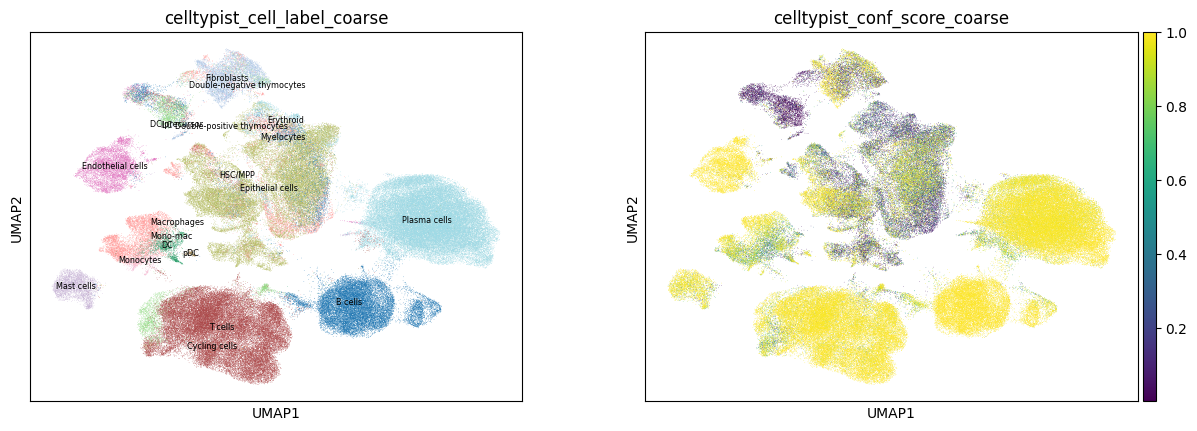

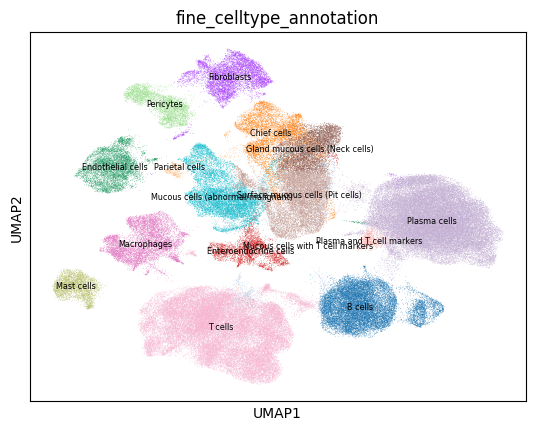

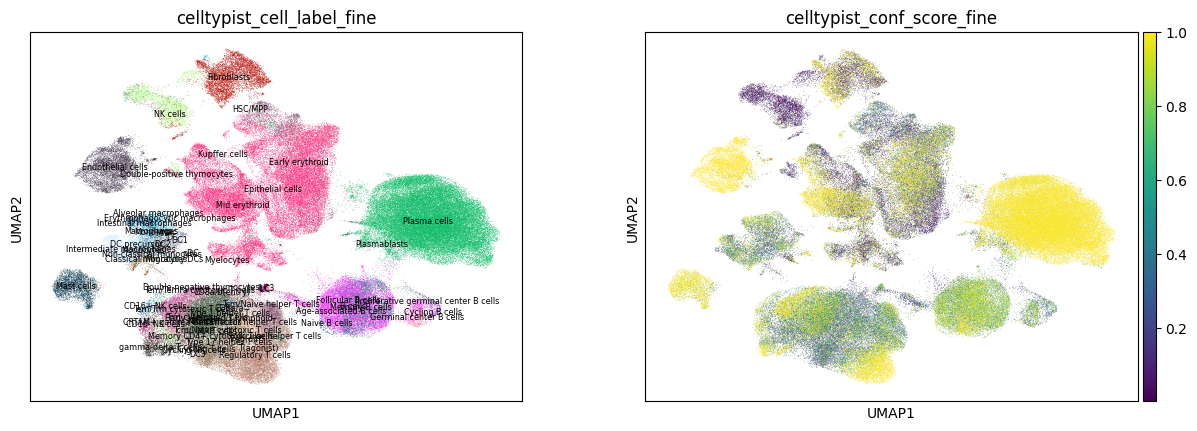

In [21]:
sc.pl.umap(adata,color=['celltypist_cell_label_coarse', 'celltypist_conf_score_coarse'],
           #groups=['NK cells', 'NKT cells',],
           legend_loc='on data',
           legend_fontsize='xx-small', legend_fontweight='normal',
           )
sc.pl.umap(adata, color=['fine_celltype_annotation'], legend_loc='on data',
           legend_fontsize='xx-small', legend_fontweight='normal',
           )
sc.pl.umap(adata,color=['celltypist_cell_label_fine', 'celltypist_conf_score_fine'],
           #groups=['NK cells', 'NKT cells',],
           legend_loc='on data',
           legend_fontsize='xx-small', legend_fontweight='normal',
           )


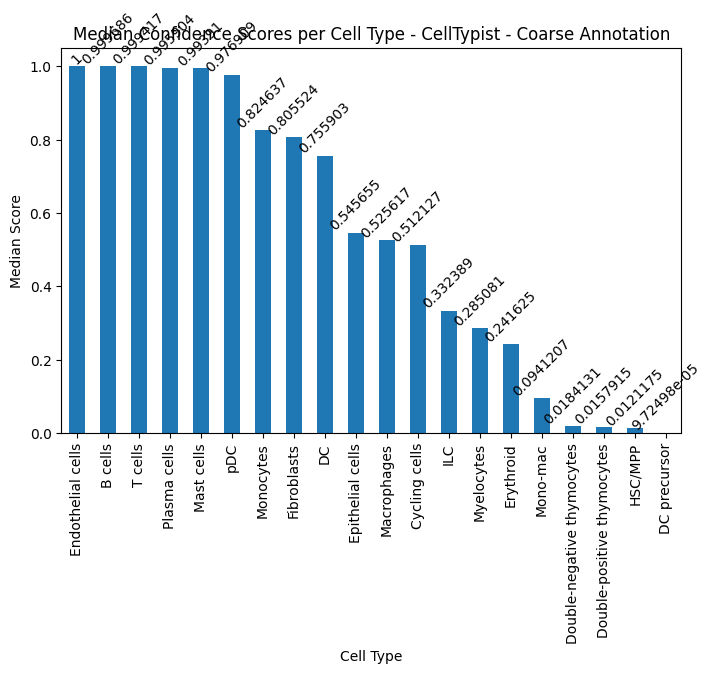

In [22]:
# median confidence score per cell type - celltypist - coarse annotation

ax =  adata.obs.groupby('celltypist_cell_label_coarse')['celltypist_conf_score_coarse'].median().sort_values(ascending=False).plot(kind='bar', figsize=(8, 5))
labels = ax.bar_label(ax.containers[0])
for label in labels:
    label.set_rotation(45)
plt.xlabel('Cell Type')
plt.ylabel('Median Score')
plt.title('Median Confidence Scores per Cell Type - CellTypist - Coarse Annotation');


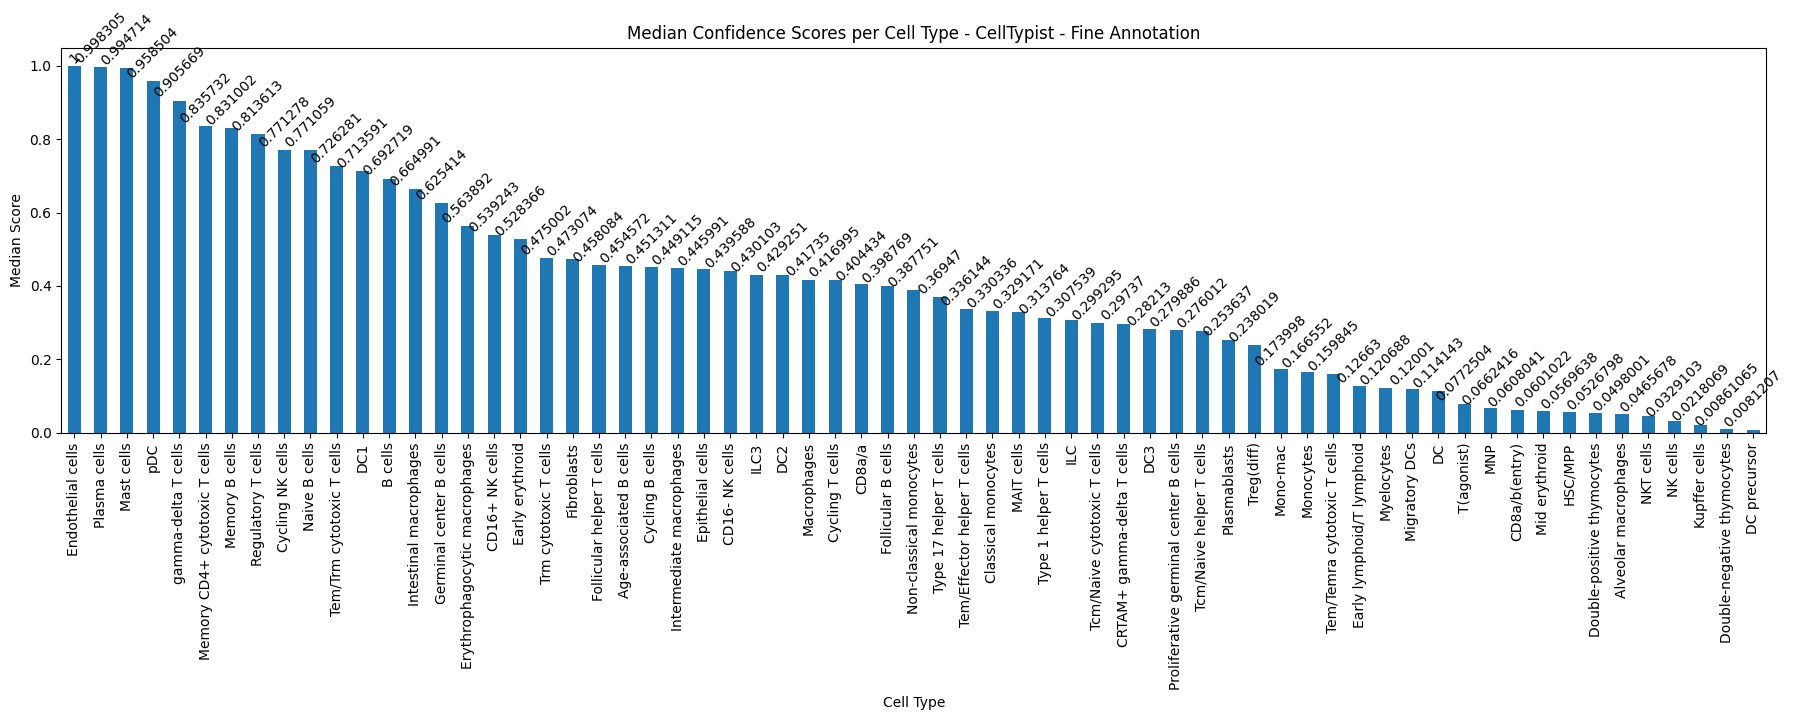

In [23]:
# median confidence score per cell type - celltypist - fine annotation

ax =  adata.obs.groupby('celltypist_cell_label_fine')['celltypist_conf_score_fine'].median().sort_values(ascending=False).plot(kind='bar', figsize=(22, 5))
labels = ax.bar_label(ax.containers[0])
for label in labels:
    label.set_rotation(45)
plt.xlabel('Cell Type')
plt.ylabel('Median Score')
plt.title('Median Confidence Scores per Cell Type - CellTypist - Fine Annotation');



In [28]:
# filter for high-confidence predictions of celltypes
high_conf_coarse = adata.obs[adata.obs['celltypist_conf_score_coarse'] > 0.9]
high_conf_fine = adata.obs[adata.obs['celltypist_conf_score_fine'] > 0.9]

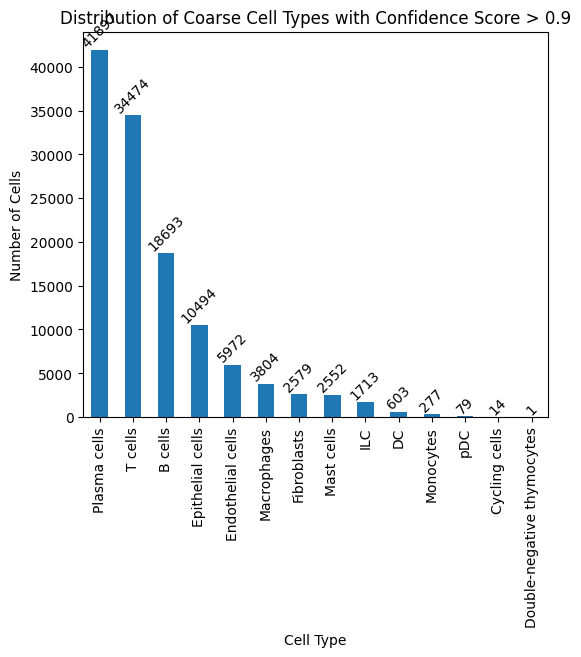

In [29]:
# distribution of predicted celltypes - CellTypist coarse
cell_counts = high_conf_coarse['celltypist_cell_label_coarse'].value_counts()

ax =  cell_counts[cell_counts > 0].sort_values(ascending=False).plot(kind='bar', figsize=(6, 5))
labels = ax.bar_label(ax.containers[0])
for label in labels:
    label.set_rotation(45)
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.title('Distribution of Coarse Cell Types with Confidence Score > 0.9');

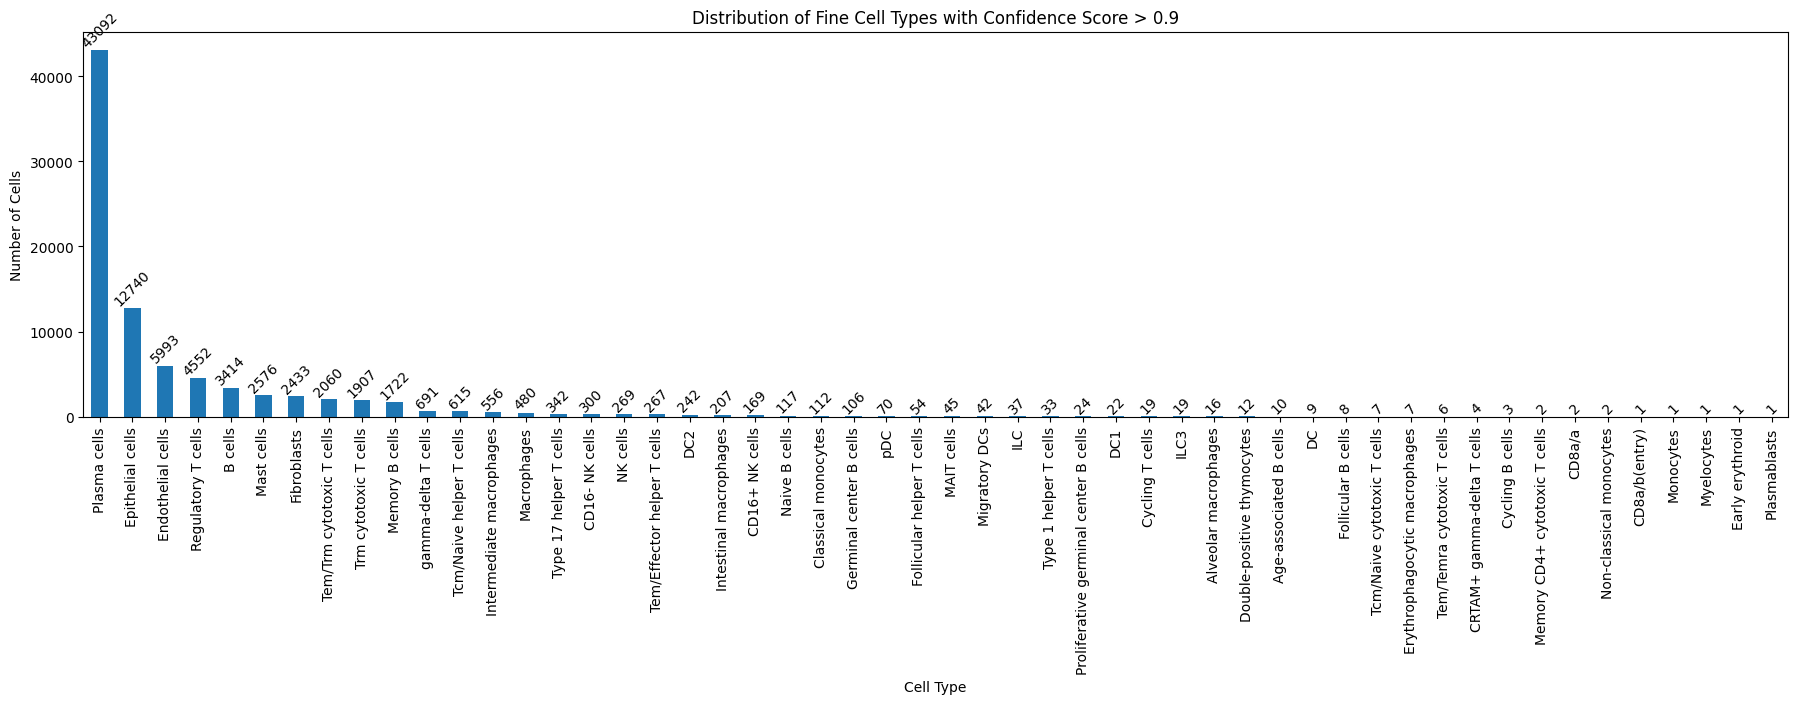

In [30]:
# distribution of predicted celltypes - CellTypist fine
cell_counts = high_conf_fine['celltypist_cell_label_fine'].value_counts()

ax = cell_counts[cell_counts > 0].sort_values(ascending=False).plot(kind='bar', figsize=(22, 5))
labels = ax.bar_label(ax.containers[0])
for label in labels:
    label.set_rotation(45)
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.title('Distribution of Fine Cell Types with Confidence Score > 0.9');


In [31]:
from scipy.sparse import issparse
adata.X = adata.layers['counts']
issparse(adata.X)

True

In [32]:
# save .h5ad
adata.write('/content/drive/MyDrive/GC_scRNAseq_annotated.h5ad', compression='gzip')

---

In [2]:
!pip list

Package                          Version
-------------------------------- -------------------
absl-py                          1.4.0
accelerate                       0.34.2
aiohappyeyeballs                 2.4.0
aiohttp                          3.10.5
aiosignal                        1.3.1
alabaster                        0.7.16
albucore                         0.0.16
albumentations                   1.4.15
altair                           4.2.2
anndata                          0.10.9
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_api_compat                 1.8
array_record                     0.5.1
arviz                            0.19.0
astropy                          6.1.3
astropy-iers-data                0.2024.9.16.0.32.21
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                      